
<hr style="border-width:2px;border-color:#A93226">

# <div align="center">TP: Optimisation: Méthodes d'optimisation pour la régression logistique pénalisée lasso</div>


<hr style="border-width:2px;border-color:#A93226">

## <div align="center">Odélia Guedj et Thomas Marcoux Pépin </div>
### <div align="center">18/01/2020 </div>
### <div align="center">M2 Data Science </div>



## Contexte

On veut comparer les algorithmes ISTA, FISTA, ADMM et SGD sur la régression logistique pénalisée lasso.

On considère que l'on observe les couples $(y_i,X_i)$ avec $y_i \in \{ -1, 1\}$ et $X_i \in \mathbb R^p$.

On a:
* $\mathbb{P}(y_i = 1|X_i) =\sigma(X_i\beta) =\frac{\exp(X_i\beta)}{1+\exp(X_i\beta)} = \frac{1}{1+\exp(-X_i\beta)} = \frac{1}{1+\exp(-y_i X_i\beta)}$ puisque $y_i = 1$
* $\mathbb{P}(y_i = -1|X_i) = 1 - \sigma(X_i\beta) =\frac{1}{1+\exp(X_i\beta)} = \frac{1}{1+\exp(- y_i X_i\beta)}$ puisque $y_i = -1$

Ainsi la vraisemblance au point $\beta \in \mathbb R^p$ est donnée par 
$$
\prod_{i=1}^n \frac{1}{1+\exp(-y_i X_i \beta)}.
$$

On veut donc résoudre
$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}
$$



In [1]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

from numpy.random import binomial
from numpy.linalg import norm
import time
from numpy.linalg import norm


## Simulation dans un modèle logistique

### Choix des valeurs de $n$ et $p$

In [2]:
n_features = 50
n_samples = 2000

### Choix des valeurs de $\beta^\star$

On pose $\beta^\star_j = (-1)^{j-1}\cdot \exp(\frac{-(j-1)}{10})$.

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Parameters')

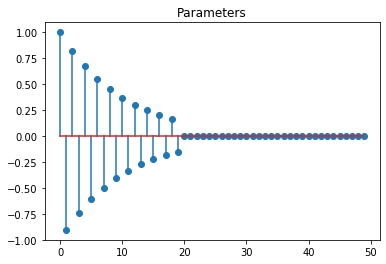

In [3]:
idx = np.arange(n_features)
params = (-1) ** idx  * np.exp(-idx / 10.)
params[20:] = 0.
plt.stem(params)
plt.title("Parameters")

### Simulation de la matrice X (features)

In [4]:
# Correlation
rho = 0.1

# Matrice de covariance Toeplitz : 1 sur la diag et répétition des colonnes
np.set_printoptions(precision=2) # pour simplifier l'affichage, 2 décimales
cov = toeplitz(rho ** np.arange(0, n_features))

# Simulation d'un vecteur gaussien de taille n avec cette matrice de covariance
features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

$X \sim \mathcal{N}(0,\Sigma)$ où $\Sigma$ = cov

Le Lasso donne de mauvais résultats lorsqu'il y a beaucoup de corrélation entre les variables. C'est pourquoi on choisit $\rho$ petit.

### Simulations des $y_i$

**Fontion sigmoïd**: Pour éviter les overflows on différencie les cas positifs des cas négatifs.

* Si $t \leq 0$, $\sigma(t) = \frac{\exp(t)}{1 + \exp(t)}$
* Si $t \geq 0$, $\sigma(t) = \frac{1}{1+\exp(-t)} $


In [5]:
def sigmoid(t):
    idx = t>0
    out = np.empty(t.size)
    out[idx] = 1/ (1. + np.exp(-t[idx]))
    exp_t = np.exp((t[~idx]))
    out[~idx] = exp_t / (1. + exp_t)
    return out

**Fonction simu_log_reg**: pour $n$, $\beta^\star$ et $\rho$ renvoie une matrice de features et un vecteur de labels.

Transformation nécessaire: la Régression Logistique suppose $Y \in \{0,1\}$ alors qu'ici $Y \in \{-1,1\}$.  
On pose alors:
$$2Y_{i,logit}-1 = Y_i$$
Ainsi si $Y_{i,logit}$ vaut 1, $Y_i$ vaut 1 et si $Y_{i,logit}$ vaut 0, $Y_i$ vaut -1.


In [6]:
def simu_logreg(n_samples,params=params,rho=0.1):
    """ simulation in a logistic regression model 
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    n_samples : `int`, 
        Number of samples to simulate
    rho : `float`, default=0.1
        Correlation of the features
        
    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    
    n_features = params.size
    
    cov = toeplitz(rho ** np.arange(0, n_features))
    
    features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    
    pis = sigmoid(features.dot(params))
    
    labels = 2 *  binomial(1,pis, n_samples) - 1
    
    return((features,labels))

Application:

In [7]:
X,y = simu_logreg(2000)
print(y.shape)
print(X.shape)

(2000,)
(2000, 50)


## Objectif: gradient sans lasso (quand $\lambda=0$)

**Classe Logreg:** Calcule:
* la loss, 
* le gradient de la loss, 
* le hessien de la loss, 
* l'objectif du modèle
* la constante de lipschitz

**Fonction de coût** 
(Les paramètres sont notés $w$ dans cette section).


$
\begin{aligned}
loss(w,X,y) &= \frac{1}{n} \sum_{i = 1}^n \log\left(1+\exp(-y_i X_i^T w)\right) \\ &= \frac{-1}{n}\sum_{i = 1}^n \log \left(\frac{1}{1+\exp(-y_i X_i^T w)}\right)\\ &= \frac{-1}{n}\sum_{i = 1}^n \log \left( \sigma(y_i X_i^T w) \right) \\ &= \frac{-1}{n}\sum_{i = 1}^n \log(\frac{\exp(y_i X_i^T w)}{1 + \exp(y_i X_i^T w)}) \\ & = \frac{1}{n}\sum_{i = 1}^n \log(1 + \exp(y_i X_i^T w)) - y_i X_i^T w
\end{aligned}
$

**Dérivée de la sigmoid**

Or, $$\sigma(t) = \frac{\exp(t)}{1+\exp(t)}$$ donc $$\sigma '(t) = \sigma(t)(1-\sigma(t))$$

**Gradient de la loss**

$
\begin{aligned}
\nabla_w loss(w,X,y) &= \frac{-1}{n}\sum_{i = 1}^n \nabla_w \log \sigma(y_i X_i^T w) \\ &= \frac{-1}{n}\sum_{i = 1}^n \frac{\nabla_w \sigma(y_i X_i^T w)}{\sigma(y_i X_i^T w)} \\ &= \frac{-1}{n}\sum_{i = 1}^n \frac{y_i X_i^T \sigma(y_i X_i^T w)(1-\sigma(y_i X_i^T w))}{\sigma(y_i X_i^T w)} \\ &= \frac{-1}{n}\sum_{i = 1}^n y_i X_i^T (1-\sigma(y_i X_i^T w))
\end{aligned}
$

**Hessien de la loss**

$ \begin{aligned}
\nabla^2_w loss(w,X,y) &=\nabla_w \left( \frac{-1}{n}\sum_{i = 1}^n y_i X_i^T (1-\sigma(y_i X_i w))\right) \\ &= \frac{-1}{n}\sum_{i = 1}^n y_i X_i^T \nabla_w(1-\sigma(y_i X_i w))\\ &= \frac{1}{n}\sum_{i = 1}^n y_i X_i^T \nabla_w \sigma(y_i X_i w)\\ &= \sum_{i = 1}^n (y_i X_i^T)(y_i X_i^T)^T \sigma(y_i X_i w)(1-\sigma(y_i X_i w)) \\ & = \sum_{i = 1}^n X_i^T X_i \sigma(y_i X_i w)(1-\sigma(y_i X_i w))
\end{aligned}
$

Car $\forall i = 1,...,n ~ y_i^2 = 1$

Pour l'implémentation on se sert de la fonction diag() en $\sigma(y_i X_i w)(1-\sigma(y_i X_i w))$ : produit élément par élément.

https://medium.com/@papillonbee/logistic-regression-from-scratch-with-gradient-descent-and-newtons-method-ff4307e3cb30

**Constante de lipschitz**

$
\begin{aligned}
    \left| \frac{-1}{n}\sum_{i = 1}^n y_i X_i^T (1-\sigma(y_i X_i w)) + \frac{-1}{n}\sum_{i = 1}^n y_i X_i^T (1-\sigma(y_i X_i  \tilde{w})) \right| &= \frac{1}{n} \left| \sum_{i = 1}^n y_i X_i^T \left( \sigma(y_i X_i  \tilde{w}) - \sigma(y_i X_i w) \right) \right| \\ &\leq \frac{1}{n} \frac{1}{4} \sum_{i = 1}^n \left| X_i^T X_i y_i^2 \right| = \frac{1}{n} \frac{1}{4} = \|X_i \|^2 |w-\tilde{w}|
\end{aligned}
$

In [8]:
class Logreg:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb): #initialisation
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w):  #calcul de la loss
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,w): #calcul du gradient de la loss
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples

    def objective(self,w): #calcul de l'objectif du modèle
        return(self.loss_logreg(w))
    
    def lip_const(self): #calcul de la constante de lipschitz
        return np.sum(norm(self.X, axis = 0, ord = 2))/ (4*self.n_samples)
    
    def hessian(self,w): #calcul du hessien de la loss
        u = self.y * self.X.dot(w)
        v = sigmoid(u)*(1-sigmoid(u))
        return X.T.dot(np.diag(v)).dot(X)/self.n_samples

Application:

In [9]:
np.set_printoptions(precision=2)
model_logreg = Logreg(X,y,0.1)
print('Constante de Lipschitz pour le model_logreg:', ("%.2e" % model_logreg.lip_const()).rjust(8))

Constante de Lipschitz pour le model_logreg: 2.79e-01


On vérifie que la méthode implémentée dans python nous donne des résultats similaires pour le calcul du gradient.

In [10]:
from scipy.optimize import check_grad
print('Différence entre le gradient caculé par python et par notre classe Logreg:', check_grad(model_logreg.loss, model_logreg.grad, params))

Différence entre le gradient caculé par python et par notre classe Logreg: 1.5834255960350702e-08


# Descente de gradient et algorithme de Newton

L'algorithme de descente de gradient est un algorithme itératif qui cherche à minimiser une fonction convexe.
A chaque itération $q$, on fait un pas dans la direction qui fait décroitre le plus vite la fonction à minimiser.
Dans notre contexte on cherche à minimiser la loss:

In [11]:
def gd(model, w0, step = None, n_iter=50, verbose=True):
    """
    Gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step==None:
            step = 1/model.lip_const()
    #######################################################################
        w_new[:] = w - step*model.grad(w)
        w[:] = w_new 
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [12]:
def newton(model, w0,n_iter=50, verbose=True):
    """
    Newton algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching Newton Algorithm (with GD solver) ...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
    #######################################################################
        w_new[:] = w - np.linalg.inv(model.hessian(w)).dot(model.grad(w))
        w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [13]:
w0 = np.zeros(n_features)
n_iter = 60

w_gd , obj_gd = gd(model_logreg,w0)

start = time.time()

w_newton, obj_newton =newton(model_logreg,w0)

end = time.time()


print("Temps de calcul par l'algorithme de Newton:", round(end - start,3), "sec")


Lauching GD solver...
   it    |   obj   
       0 | 5.10e-01
      10 | 4.58e-01
      20 | 4.58e-01
      30 | 4.58e-01
      40 | 4.58e-01
      50 | 4.58e-01
Lauching Newton Algorithm (with GD solver) ...
   it    |   obj   
       0 | 4.84e-01
      10 | 4.58e-01
      20 | 4.58e-01
      30 | 4.58e-01
      40 | 4.58e-01
      50 | 4.58e-01
Temps de calcul par l'algorithme de Newton: 1.098 sec


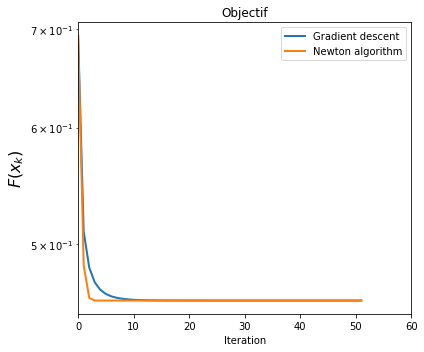

In [14]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_gd , label="Gradient descent", lw=2) 
plt.plot(obj_newton , label="Newton algorithm", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

On remarque que, pour les 10 premières itérations, l'algorithme de Newton est plus précis que la descente de gradient. Pour $q>10$ les résultats des deux méthodes sont semblables.

# Descente de gradient proximal

On retourne au cas de la régression logistique pénalisée lasso.

**Classe logreg_l1**: Similaire à **logreg** avec ajout d'une méthode  qui calcule l'opérateur proximal de la norme 1, en changeant la méthode objectif.

In [15]:
class Logreg_l1:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb): #initialisation
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w): #calcul de la loss
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,X,y,w): #calcul du gradient
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples

    def pen(self,w): #calcul de la pénalité
        return self.lamb*norm(w,1)        
    
    def prox(self,w,step): #calcul de l'operateur proximal
        return np.sign(w)*(np.abs(w) - self.lamb)*(np.abs(w) > self.lamb)

    def objective(self,w): #calcul de l'objectif
        return(self.loss_logreg(w) + self.pen_l1(w))
    
    def lip_const(self,w): #calcul de la constante de lipschitz
        return np.sum(norm(self.X,2,axis=0)) / (4*self.n_samples)  
 

In [16]:
X,y = simu_logreg(2000)
lamb=0
print(y.shape)
print(X.shape)

model_logreg_l1 = Logreg_l1(X,y,lamb)

(2000,)
(2000, 50)


La fonction  **pgd** code l'algorithme de descente de gradient proximal (sur le modèle de la fonction **gd**).

In [17]:
def pgd(model, w0, step = None, n_iter=50, verbose=True):
    """Proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (model.lip_const(w))
    #######################################################################
        w_new[:] = model.prox(w - step*model.grad(X,y,w), step)
        w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [18]:
w0 = np.zeros(n_features)
n_iter = 60
w_pgd , obj_pgd = pgd(model_logreg_l1,w0,n_iter=50)

Lauching GD solver...
   it    |   obj   
       0 | 4.8731772484e-01
      10 | 4.2211430402e-01
      20 | 4.2126462175e-01
      30 | 4.2122552364e-01
      40 | 4.2122344260e-01
      50 | 4.2122332835e-01


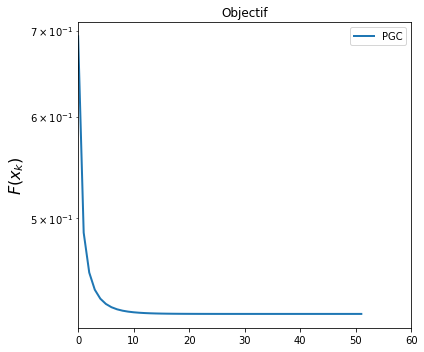

In [19]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd , label="PGC", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

On peut également décider de provoquer un arrêt prematuré quand $tol = 10^{-3} > \frac{\|w_{\text{new}} - w\|}{\|w\|}$

In [20]:
def pgd2(model, w0, step = None, n_iter=50, verbose=True, eps=1e-03):
    """Proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
         if step == None:
            step = 1 / (10* model.lip_const(w))
    #######################################################################
         w_new[:] = model.prox(w - step*model.grad(X,y,w), step)
         while((np.abs(w_new - w)/ np.abs(w)).all()>= eps): 
            w[:] = w_new
    #######################################################################
            obj = model.loss(w) 
            objectives.append(obj)         
            if k % 10 == 0 and verbose:  
                print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))                  
                     
            return w, np.array(objectives)

In [40]:
w_pgd2 , obj_pgd2 = pgd2(model_logreg_l1, w0)

Lauching GD solver...
   it    |   obj   
       0 | 3.14e+00


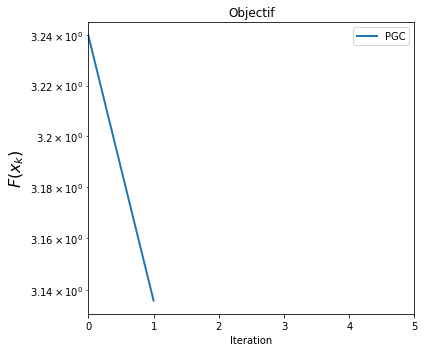

In [45]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd2 , label="PGC", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.title('Objectif')
plt.xlim((0, 5))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

L'objectif est alors atteint en une seule itération pour $tol=10^{-3}$.

# Descente de gradient stochastique proximal

- Coder un algorithme de descente de gradient stochastique proximal pour ce problème
- Comparer ses performances au PGD classique

In [42]:
def spgd(model, w0, step = None, n_iter=50, verbose=True): #utiliser batch_size=20 ou pas (mm res)
    """Stochastic proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape

    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (model.lip_const(w))
    #######################################################################
        for l in range(n_samples): 
                i = np.random.choice(n_samples, n_samples, replace=False)
                w_new[:] = model.prox(w - step*model.grad(X[i], y[i],w), step)
                w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [24]:
w0 = np.ones(n_features)
n_iter = 40
w_spgd , obj_spgd = spgd(model_logreg_l1,w0)

Lauching GD solver...
   it    |   obj   
       0 | 4.2122332166e-01
      10 | 4.2122332166e-01
      20 | 4.2122332166e-01
      30 | 4.2122332166e-01
      40 | 4.2122332166e-01
      50 | 4.2122332166e-01


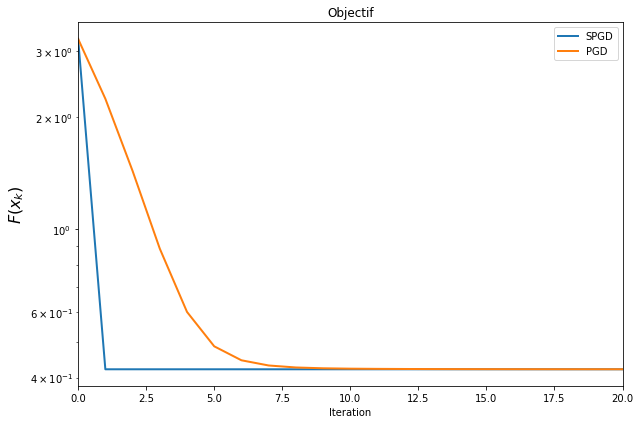

In [44]:
plt.figure(figsize=(9,6))
plt.yscale("log")
plt.plot(obj_spgd , label="SPGD", lw=2) 
plt.plot(obj_pgd , label="PGD", lw=2) 
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.title('Objectif')
plt.xlim((0, 20))
plt.tight_layout()

La méthode  **SPGD** donne de meilleurs résultats que **PGD** pour un même nombre d'itérations. Au dela de $10$ itérations, les résultats sont semblables.

# ADMM 

- Coder un algorithme ADMM pour ce problème
- Comparer ses performances au PGD classique et au SPGD

In [26]:
def admm(model, w0, step = None, n_iter=50, verbose=True):
    """Alternating Direction Method of Multipliers (ADMM)
    """
    w = w0.copy()
    w1 = w0.copy()
    v = w0.copy()
    v1 = w0.copy()
    z = w0.copy()
    z1 = w0.copy()
    n_samples, n_features = model.X.shape
   
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (model.lip_const(w))

    #######################################################################
        w1[:] = np.linalg.inv(step*(model.X.T).dot(model.X) + np.identity(n_features)).dot(step*model.X.T.dot(y) + (z-v))
        z1[:] = model.prox((w1 + v), step)
        v1[:] = v + (w1 - z1)
        v[:] = v1
        z[:] = z1
        w[:] = w1
    #######################################################################
    
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [27]:
w0 = np.ones(n_features)
#n_iter = 20
w_admm , obj_admm = admm(model_logreg_l1, w0)
w_spgd , obj_spgd = spgd(model_logreg_l1, w0)
w_pgd , obj_pgd = pgd(model_logreg_l1, w0)

Lauching GD solver...
   it    |   obj   
       0 | 5.3438964261e-01
      10 | 5.3437079800e-01
      20 | 5.3437079800e-01
      30 | 5.3437079800e-01
      40 | 5.3437079800e-01
      50 | 5.3437079800e-01
Lauching GD solver...
   it    |   obj   
       0 | 4.2122332166e-01
      10 | 4.2122332166e-01
      20 | 4.2122332166e-01
      30 | 4.2122332166e-01
      40 | 4.2122332166e-01
      50 | 4.2122332166e-01
Lauching GD solver...
   it    |   obj   
       0 | 2.2390896924e+00
      10 | 4.2229911713e-01
      20 | 4.2128303329e-01
      30 | 4.2122678596e-01
      40 | 4.2122351580e-01
      50 | 4.2122333245e-01


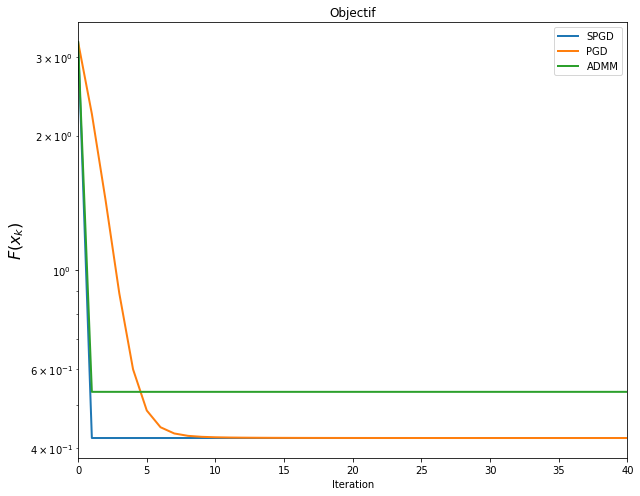

In [28]:
plt.figure(figsize=(9, 7))
plt.yscale("log")
plt.plot(obj_spgd , label="SPGD", lw=2) 
plt.plot(obj_pgd , label="PGD", lw=2) 
plt.plot(obj_admm , label="ADMM", lw=2) 
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.xlabel('Iteration')
plt.legend(loc='upper right')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()